# Basic Train/Test Experiment on the WESAD data set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Import library functions

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

#Import mFlow Functions
from cerebralcortex.kernel import Kernel
from Blocks.data_loader_wesad import wesad_data_loader
from Blocks.filter import ColumnSelectFilter
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, addTarget, __ExpTrainTest
from Blocks.ccwrapper import ccwrapper, cc_to_pandas, ccTake
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport,__DataYieldReport
from Workflow.workflow import workflow

#Import cc3 functions
from cerebralcortex.algorithms.ecg.autosense_data_quality import ecg_autosense_data_quality
from cerebralcortex.algorithms.ecg.autosense_rr_interval import get_rr_interval
from cerebralcortex.algorithms.ecg.hrv_features import get_hrv_features
from cerebralcortex.algorithms.stress_prediction.ecg_stress import compute_stress_probability
from cerebralcortex.algorithms.stress_prediction.stress_episodes import compute_stress_episodes
from cerebralcortex.algorithms.stress_prediction.stress_imputation import forward_fill_data, impute_stress_likelihood
from cerebralcortex.algorithms.utils.feature_normalization import normalize_features

#Import SKLearn Functions
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


## Define and execute the workflow

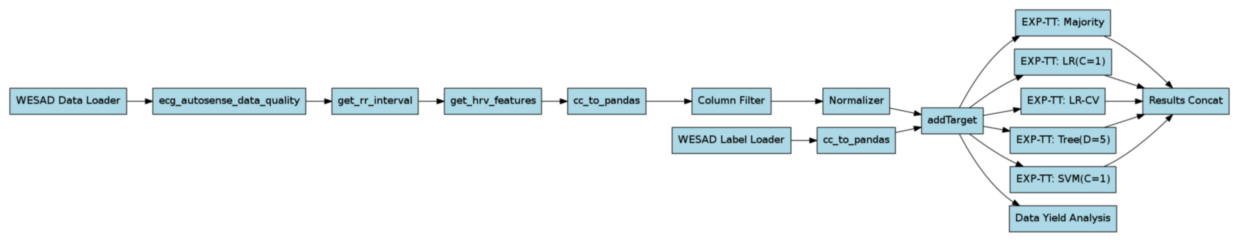

In [20]:
#Define data set properties
Fs         = 700
sensor     = "respiban"
features   = ["var", "iqr", "vlf", "lf", "hf", "lfhf", "mean", "median", "80th", "20th", "heartrate"]

#Define models and metrics
metrics    = [accuracy_score]
models = {
              "Majority":  DummyClassifier(strategy="most_frequent"),
              "LR(C=1)":   LogisticRegression(C=1, solver="lbfgs",max_iter=1000),
              "LR-CV":     GridSearchCV(LogisticRegression(solver="lbfgs",max_iter=1000), 
                                cv=3, verbose=2, param_grid={"C":[1e-3,1e-2,1e-1,1,10]}),
              "Tree(D=5)": tree.DecisionTreeClassifier(max_depth=5),
              "SVM(C=1)":  SVC(C=1, gamma="auto", max_iter=100)
        }

#Define Workflow
dsd,dsl    = wesad_data_loader(data_size="all")
dfl        = cc_to_pandas(dsl,participant_field="user",datetime_field="timestamp",cache_filename="Temp/wesad_labels.pkl")
dsd        = ccwrapper(ecg_autosense_data_quality, dsd, sort_field="timestamp", sensor_name=sensor, Fs=Fs)
dsd        = ccwrapper(get_rr_interval,dsd, sort_field="timestamp",Fs=Fs)
dsd        = ccwrapper(get_hrv_features,dsd, sort_field="timestamp")
dfd        = cc_to_pandas(dsd,participant_field="user",datetime_field="timestamp",cache_filename="Temp/wesad_data.pkl")
dfd        = ColumnSelectFilter(dfd ,features)
dfd        = Normalizer(dfd);
df         = addTarget(dfd,dfl)
results    = ExpTrainTest(df, models, metrics=metrics,grouped=False);
results    = ResultsConcat(results)
yieldreport= DataYieldReport(df,names="WESAD All") 

#Execute workflow
flow       = workflow([df, results, yieldreport]);
output     = flow.run(backend="sequential", monitor=True);


## Display the experimental results

In [21]:
display(output["Results Concat"]["report"])

,accuracy_score
Majority,0.439863
LR(C=1),0.457045
LR-CV,0.457045
Tree(D=5),0.446735
SVM(C=1),0.360825


## Display the data yield analysis

In [22]:
display(output['Data Yield Analysis']["report"])

,#Individuals,#Individuals with Data,#Instances,#Labeled Instances,%Labeled Instances,#Features,#Observed Feature Values,%Observed Feature Values
0,15,15,1452,1452,100.0,11,15972,100.0


## Display the dataset

In [23]:
output["addTarget"]["dataframe"]

median       iqr      80th       var        lf  \
ID  Time                                                                    
s2  2017-05-22 02:15:00  0.253600  0.310274  0.195380  0.052506 -1.232492   
    2017-05-22 02:16:00 -0.230547 -0.387798 -0.363908 -0.233086 -0.113430   
    2017-05-22 02:17:00  0.092221 -0.487540 -0.085010 -0.335237 -0.073846   
    2017-05-22 02:18:00 -0.130640 -0.000003 -0.186427 -0.223292 -0.325150   
    2017-05-22 02:19:00  0.188281 -0.088629  0.087996 -0.104612  0.156300   
...                           ...       ...       ...       ...       ...   
s17 2017-08-11 03:53:00  1.356385  1.340730  1.366142  2.746489 -0.033246   
    2017-08-11 03:54:00 -0.092221  1.878121  0.536913  1.996183  0.723119   
    2017-08-11 03:55:00  0.983668  1.296408  1.099179  1.454065 -0.514617   
    2017-08-11 03:56:00  1.183478  0.686989  1.154359  0.791173 -0.154091   
    2017-08-11 03:57:00 -0.215177  1.518021  0.105889  2.335894 -0.203058   

                              vlf      20th        hf      mean      lfhf  \
ID  Time                                                                    
s2  2017-05-22 02:15:00 -0.377639  0.220619  0.953771  0.206681 -0.798556   
    2017-05-22 02:16:00  0.567751 -0.110306  0.109449 -0.236218 -0.103734   
    2017-05-22 02:17:00  0.421430  0.261351  0.071876  0.074385 -0.068568   
    2017-05-22 02:18:00 -0.488585 -0.072973  0.299848 -0.135954 -0.275372   
    2017-05-22 02:19:00 -0.110323  0.280015 -0.160244  0.153341  0.159548   
...                           ...       ...       ...       ...       ...   
s17 2017-08-11 03:53:00 -0.380093  0.627920  0.032652  1.128755 -0.031366   
    2017-08-11 03:54:00  1.083063 -0.149342 -0.853441  0.086350  1.000008   
    2017-08-11 03:55:00 -0.449998  0.734828  0.456435  0.879619 -0.409160   
    2017-08-11 03:56:00 -0.387450  1.162492  0.147374  1.101272 -0.138776   
    2017-08-11 03:57:00  0.351759 -0.497240  0.192167 -0.154317 -0.179600   

                         heartrate  target  
ID  Time                                    
s2  2017-05-22 02:15:00  -0.238421       0  
    2017-05-22 02:16:00   0.242560       0  
    2017-05-22 02:17:00  -0.089889       0  
    2017-05-22 02:18:00   0.134150       0  
    2017-05-22 02:19:00  -0.179590       0  
...                            ...     ...  
s17 2017-08-11 03:53:00  -1.026399       4  
    2017-08-11 03:54:00   0.093833       0  
    2017-08-11 03:55:00  -0.796907       0  
    2017-08-11 03:56:00  -0.923817       0  
    2017-08-11 03:57:00   0.225537       0  

[1452 rows x 12 columns]